





I was able to get around 88% accuracy without the risk of overfitting. It's not the above 95% but I think it's still best fit.

# **Fine Tuning of Flower Classification with ResNet50**

## **Introduction:**

This notebook presents a comprehensive approach to classifying flower images using a pre-trained ResNet50 model. The ResNet50 architecture, known for its deep residual learning framework, effectively handles complex classification tasks by leveraging skip (residual) connections to mitigate issues related to vanishing gradients and model depth.

## **Objective:**

The primary objective of this project is to fine-tune a pre-trained ResNet50 model on the 102 Flower Dataset. The dataset consists of images of flowers across 102 categories. The goals of this notebook include:

**Data Preparation:** Loading and preprocessing the flower images and their corresponding labels.
**Model Definition:** Modifying the ResNet50 model for the specific classification task.
**Training and Validation:** Training the model with a focus on optimizing accuracy and preventing overfitting.
**Evaluation:** Assessing the model's performance on a validation set.


## **Methodology:**

**Data Loading and Preprocessing:** Load the dataset and split it into training, validation, and test sets. Apply image transformations to enhance model robustness, including resizing, normalization, and data augmentation.

**Model Customization:** Load the pre-trained ResNet50 model. Modify the final fully connected layer to match the number of classes in the dataset. Implement dropout to prevent overfitting.

**Training and Optimization:** Define the loss function and optimizer. Utilize a learning rate scheduler to adaptively adjust the learning rate. Implement automatic mixed precision (AMP) to optimize GPU memory usage and training speed.

**Evaluation and Early Stopping:** Monitor model performance on the validation set.
Apply early stopping to prevent overfitting and save the best model.

## **Prerequisites:**

Ensure you have the following Python packages installed:

```
torch
torchvision
albumentations
scipy
PIL
numpy
tqdm

```


You can install these packages using pip if they are not already installed:

In [ ]:
!pip install torch torchvision albumentations scipy pillow numpy tqdm


In [ ]:
# Download the dataset (adjust the link if needed)
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

# Extract the images
!tar -xzf 102flowers.tgz


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, RandomResizedCrop, HorizontalFlip, RandomBrightnessContrast, Normalize, Resize, RandomGamma
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import scipy.io
import os
from PIL import Image
import numpy as np
from torch.optim.lr_scheduler import CyclicLR
from torch.cuda.amp import autocast, GradScaler
from typing import Tuple, List, Optional

# Load the .mat files
data_dir: str = '/content/jpg'  # Path to the directory containing images
image_labels: np.ndarray = scipy.io.loadmat('/content/imagelabels.mat')['labels'][0]
setid: dict = scipy.io.loadmat('/content/setid.mat')

# Extract training, validation, and test indices
train_idx: np.ndarray = setid['trnid'][0] - 1
val_idx: np.ndarray = setid['valid'][0] - 1
test_idx: np.ndarray = setid['tstid'][0] - 1

# Custom dataset class
class FlowersDataset(Dataset):
    def __init__(self, img_dir: str, indices: np.ndarray, labels: np.ndarray, transform: Optional[Compose] = None):
        self.img_dir: str = img_dir
        self.indices: np.ndarray = indices
        self.labels: np.ndarray = labels
        self.transform: Optional[Compose] = transform

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_idx: int = self.indices[idx]
        img_path: str = os.path.join(self.img_dir, f'image_{img_idx+1:05d}.jpg')
        image: np.ndarray = np.array(Image.open(img_path).convert('RGB'))
        label: int = self.labels[img_idx] - 1

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

# Data transformations
transform_train: Compose = Compose([
    RandomResizedCrop(224, 224),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
    RandomGamma(p=0.1),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

transform_val: Compose = Compose([
    Resize(224, 224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Datasets and DataLoaders
train_dataset: FlowersDataset = FlowersDataset(data_dir, train_idx, image_labels, transform=transform_train)
val_dataset: FlowersDataset = FlowersDataset(data_dir, val_idx, image_labels, transform=transform_val)
test_dataset: FlowersDataset = FlowersDataset(data_dir, test_idx, image_labels, transform=transform_val)

train_loader: DataLoader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, drop_last=True)
val_loader: DataLoader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader: DataLoader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

# Define the model
class ResNet50WithDropout(nn.Module):
    def __init__(self, original_model: nn.Module):
        super(ResNet50WithDropout, self).__init__()
        self.features: nn.Sequential = nn.Sequential(*list(original_model.children())[:-1])
        self.fc: nn.Sequential = nn.Sequential(
            nn.Linear(2048, 102),
            nn.Dropout(0.3)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model: ResNet50WithDropout = ResNet50WithDropout(models.resnet50(pretrained=True))
model = model.to('cuda')

# Define loss, optimizer, and scheduler
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: optim.Adam = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler: CyclicLR = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=5, mode='triangular2')
scaler: GradScaler = GradScaler()

# Verbose Early Stopping
class VerboseEarlyStopping:
    def __init__(self, patience: int = 10):
        self.patience: int = patience
        self.best_acc: float = 0.0
        self.epochs_without_improvement: int = 0
        self.stopped_epoch: int = 0

    def __call__(self, epoch: int, val_acc: float, model: nn.Module, path: str) -> bool:
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            torch.save(model.state_dict(), path)
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                self.stopped_epoch = epoch
                print(f'Early stopping triggered at epoch {self.stopped_epoch + 1}. Best Validation Accuracy: {self.best_acc:.4f}')
                return True
        return False

early_stopping: VerboseEarlyStopping = VerboseEarlyStopping(patience=10)

# Training and validation loop
for epoch in range(101):  # Set a max number of epochs
    model.train()
    running_loss: float = 0.0
    running_corrects: int = 0

    for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        with autocast():
            outputs: torch.Tensor = model(inputs)
            loss: torch.Tensor = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss: float = running_loss / len(train_loader.dataset)
    epoch_acc: float = running_corrects / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss: float = 0.0
    val_corrects: int = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}'):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            with autocast():
                outputs: torch.Tensor = model(inputs)
                loss: torch.Tensor = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()

    val_loss /= len(val_loader.dataset)
    val_acc: float = val_corrects / len(val_loader.dataset)

    print(f'Epoch {epoch+1} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}')
    print(f'Epoch {epoch+1} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}')
    print(f'Epoch {epoch+1}: Learning rate is {scheduler.get_last_lr()[0]:.6f}')

    scheduler.step()

    if early_stopping(epoch, val_acc, model, 'best_model.pth'):
        break

print('Training complete.')



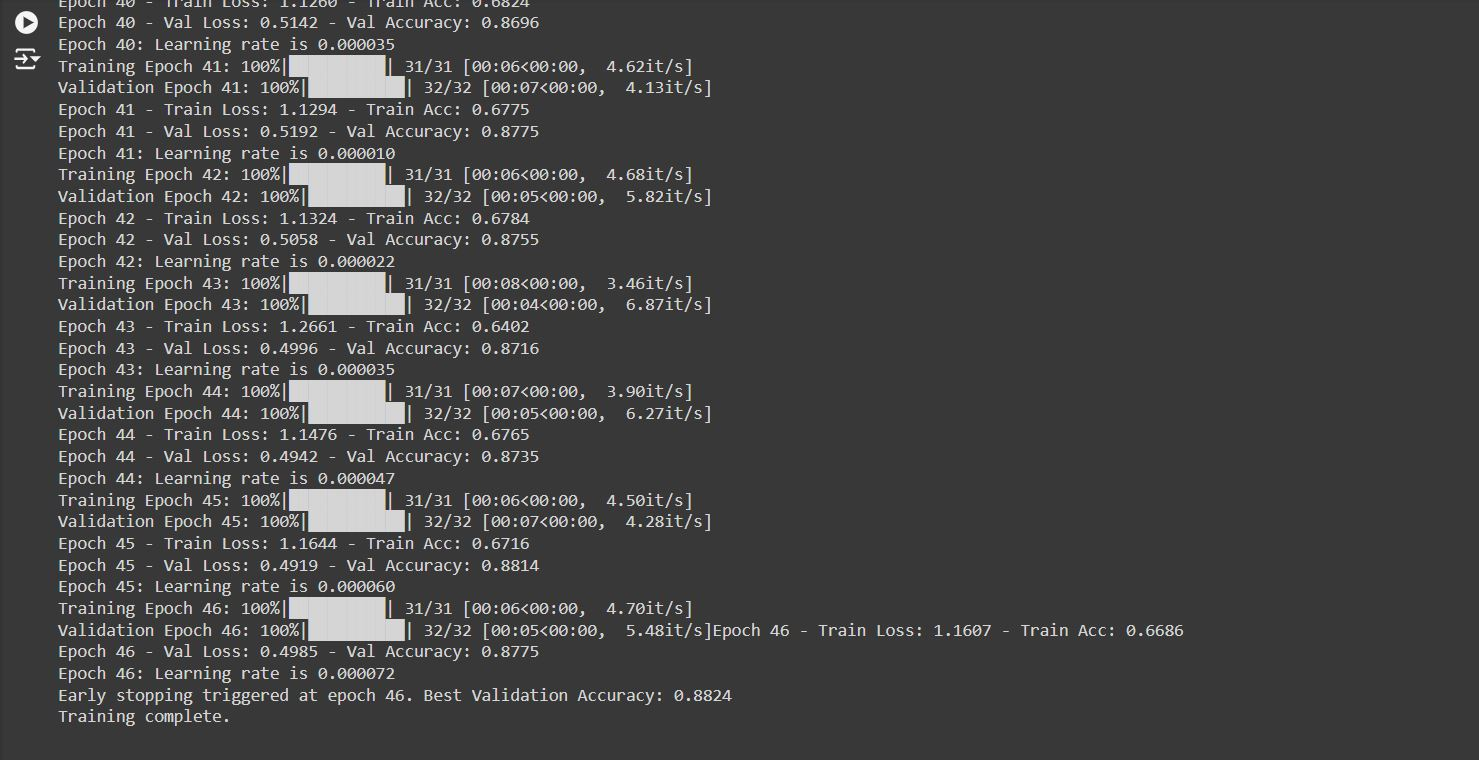

I think, it can be further improved. But at the moment it's the best I could get without the risk of overfitting.
